In [1]:
#Set up path
# import sys
# #sys.path.append('/ye/yelabstore3/guy_mm/DoubletDetection/src/doubletdetection')
# sys.path.append('/netapp/home/emccarthy/miniconda3/lib/python3.6/site-packages')
# sys.path.append('/netapp/home/emccarthy/miniconda3/bin')
# sys.path.append('/netapp/home/emccarthy/miniconda3/lib')
# sys.path.append('/netapp/home/emccarthy/miniconda3/x86_64-conda_cos6-linux-gnu/sysroot/lib')

# sys.path.append('/netapp/home/emccarthy/miniconda3/envs/scanpy/bin')
#Import libraries
import time
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import math

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=100)

/wynton/home/kimlab/hyang7/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
sample_list = pd.read_csv('../metadata/10x_bladder_tumor_normal_metadata_CD8_09262019.csv', sep = ',')

sample_list

,filename,sample,pop,treatment,tissue,patient,comp
0,161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_...,atezo2,atezo2,atezo,tumor,a2,CD8
1,170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TC...,atezo3,atezo3,atezo,tumor,a3,CD8
2,170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T8...,atezo4,atezo4,atezo,tumor,a4,CD8
3,170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/...,atezo5,atezo5,atezo,tumor,a5,CD8
4,170109_D00328_0602_AHFKK7BCXY_version_1.1_10xg...,soc1,soc1,soc,tumor,s1,CD8
5,170207_D00328_0611_AHFMGHBCXY_10x/P4/outs/filt...,soc2,soc2,soc,tumor,s2,CD8
6,170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4...,soc3,soc3,soc,tumor,s3,CD8
7,170109_D00328_0602_AHFKK7BCXY_version_1.1_10xg...,s1normal,s1normal,soc,normal,s1,CD8
8,170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4...,s3normal,s3normal,soc,normal,s3,CD8


In [3]:
RNA_files = np.array(sample_list['filename'])
RNA_files

array(['161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD8/outs/filtered_gene_bc_matrices/hg19/',
       '170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD8/outs/filtered_gene_bc_matrices/hg19/',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T8/outs/filtered_gene_bc_matrices/hg19/',
       '170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD8/outs/filtered_gene_bc_matrices/hg19/',
       '170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1TCD8/outs/filtered_gene_bc_matrices/hg19/',
       '170207_D00328_0611_AHFMGHBCXY_10x/P4/outs/filtered_gene_bc_matrices/hg19/',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T8/outs/filtered_gene_bc_matrices/hg19/',
       '170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1NCD8/outs/filtered_gene_bc_matrices/hg19/',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N8/outs/filtered_gene_bc_matrices/hg19/'],
      dtype=object)

In [4]:
#Load 10x data
#Create directories where cache folder will live
#!mkdir /ye/yelabstore3/PCI/005_production/analysis
#!mkdir /ye/yelabstore3/PCI/005_production/analysis/preprocessing
#Set directory where cahce files will save
os.chdir("/wynton/group/ye/emccarthy/EM/bladder_cancer/")

#Update all these inputs
#START
no_wells = sample_list.shape[0]

#RNA_files = np.array(sample_list['sample'])
patient = np.array(sample_list['patient'])
tissue = np.array(sample_list['tissue'])
treatment = np.array(sample_list['treatment'])
sample = np.array(sample_list['sample'])
comp = np.array(sample_list['comp'])


RNA_path_prefix = "/ye/yelabstore2/bladder_cancer/10xdata_for_backup/"
#RNA_path_suffix = "/outs/filtered_gene_bc_matrices/hg19/"
#END

#Initialize list to store adata objects
RNA_adata = [None] * no_wells


#Initialize dataframe to store cell counts
#height = 6
height = 1
width = no_wells
cell_count_df = pd.DataFrame(0, index=range(height), columns=range(width))
cell_count_df.rename(index={0:'Cells'}, inplace=True)
#Rename the columns
cell_count_df.columns = RNA_files


for i in range(no_wells):
    start = time.time()
    
    well = RNA_files[i]
    print(well)
    
    #Load RNA adata
    path = RNA_path_prefix + RNA_files[i]
#   RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=False)
    print("Loaded RNA")
    
    
    
    print("Added singlet info")
    cell_count_df[well] = [RNA_adata[i].shape[0]]
    
    print("Add cell annotations")

    RNA_adata[i].obs['patient'] = [patient[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['tissue'] = [tissue[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['treatment'] = [treatment[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['sample'] = [sample[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['comp'] = [comp[i]]*RNA_adata[i].shape[0]
    
    end = time.time()
    print(end-start, "sec")


161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD8/outs/filtered_gene_bc_matrices/hg19/
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
2.743722677230835 sec
170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD8/outs/filtered_gene_bc_matrices/hg19/
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
1.1096553802490234 sec
170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T8/outs/filtered_gene_bc_matrices/hg19/
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
1.670830249786377 sec
170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD8/outs/filtered_gene_bc_matrices/hg19/
--> This might be very slow. Consider passing `cache=True`, which enables much fas

In [5]:
cell_count_df.T

,Cells
161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD8/outs/filtered_gene_bc_matrices/hg19/,1302
170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD8/outs/filtered_gene_bc_matrices/hg19/,684
170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T8/outs/filtered_gene_bc_matrices/hg19/,1650
170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD8/outs/filtered_gene_bc_matrices/hg19/,1128
170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1TCD8/outs/filtered_gene_bc_matrices/hg19/,1997
170207_D00328_0611_AHFMGHBCXY_10x/P4/outs/filtered_gene_bc_matrices/hg19/,1912
170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T8/outs/filtered_gene_bc_matrices/hg19/,1472
170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1NCD8/outs/filtered_gene_bc_matrices/hg19/,458
170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N8/outs/filtered_gene_bc_matrices/hg19/,1723


161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


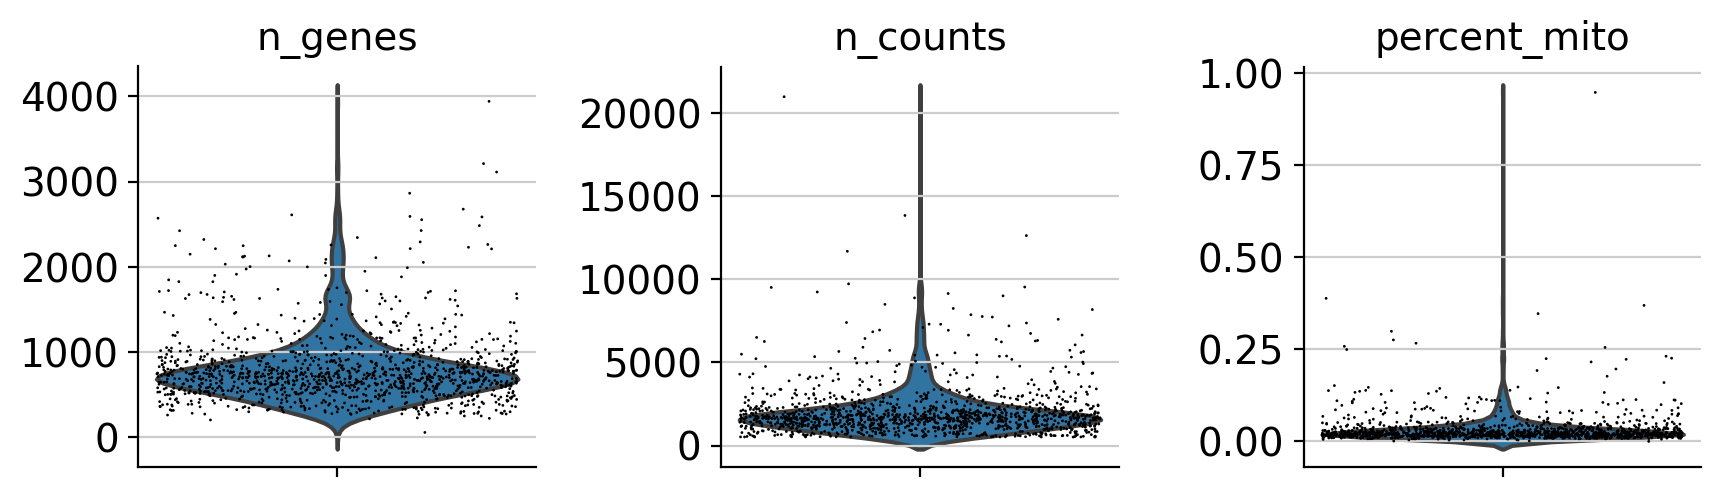

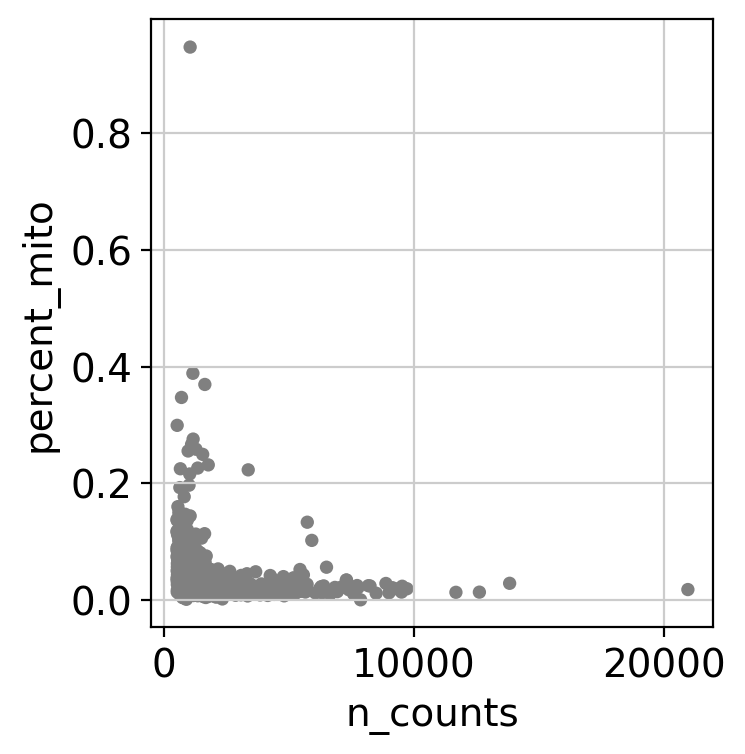

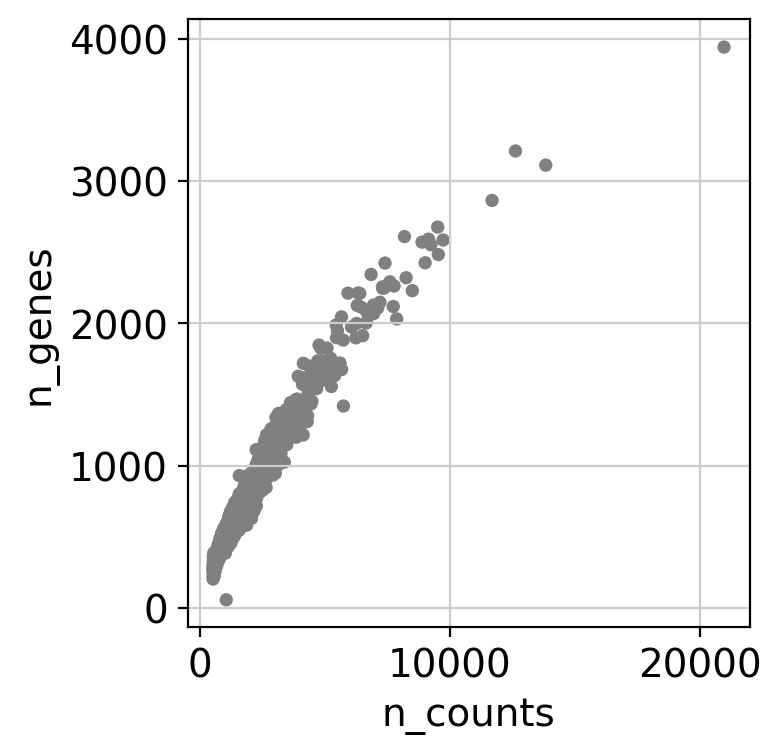

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


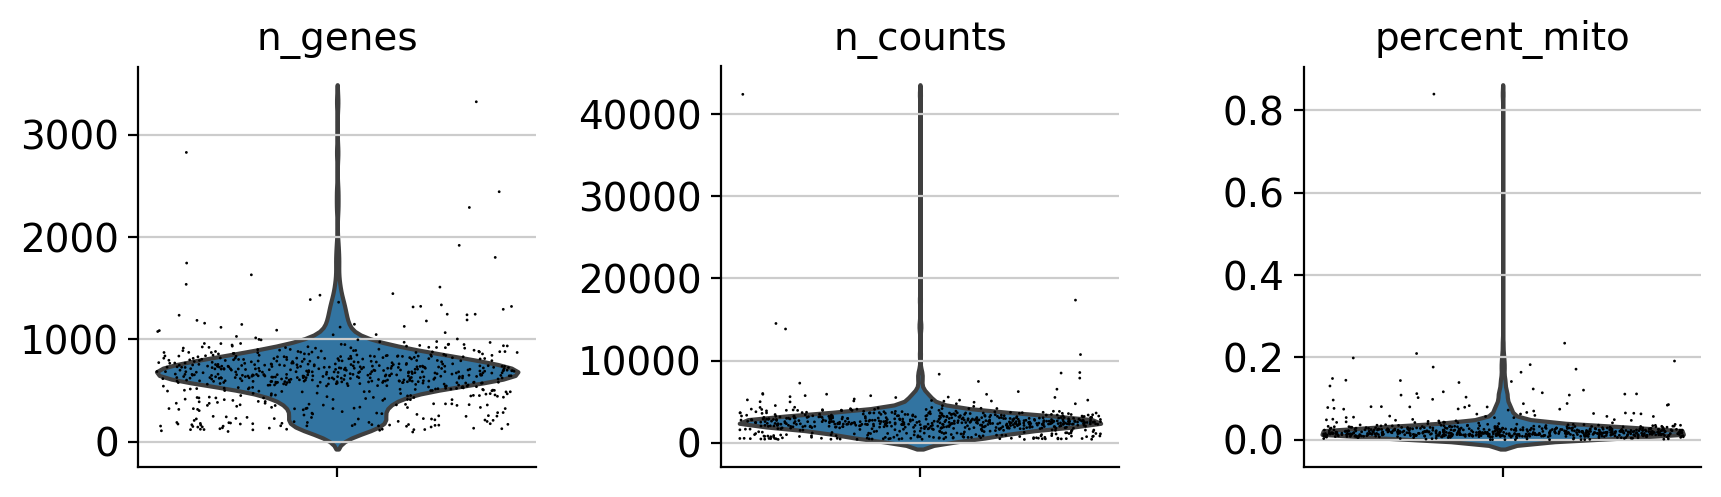

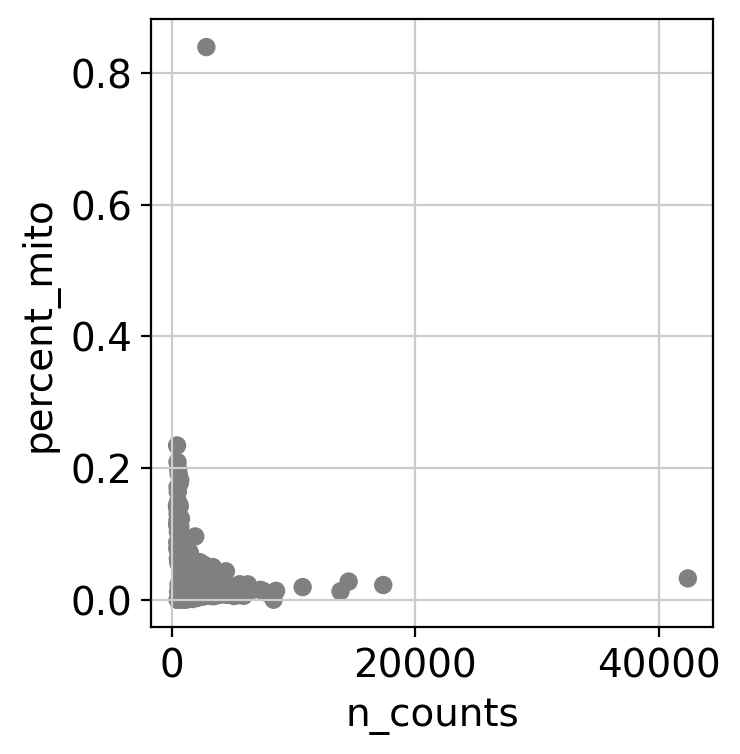

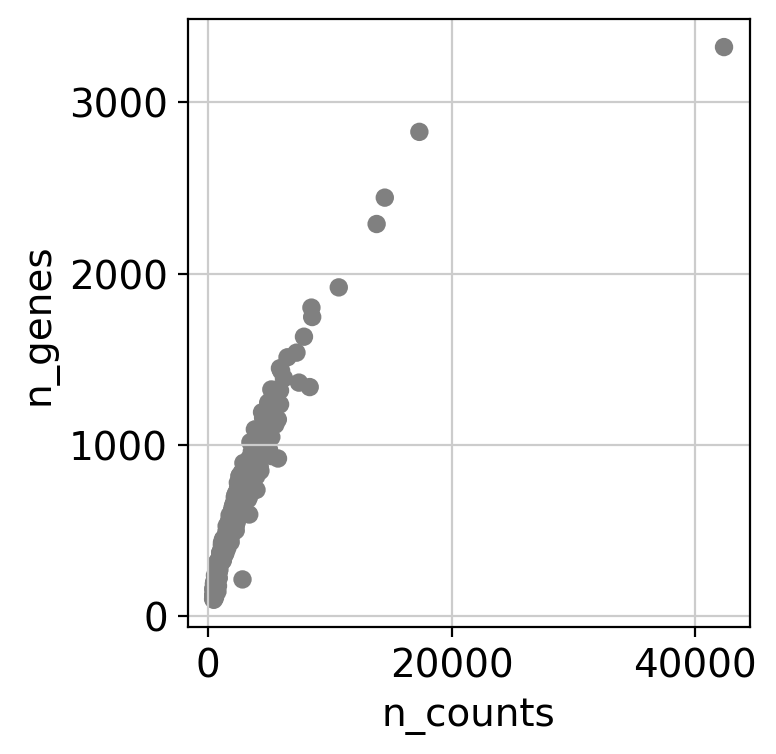

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


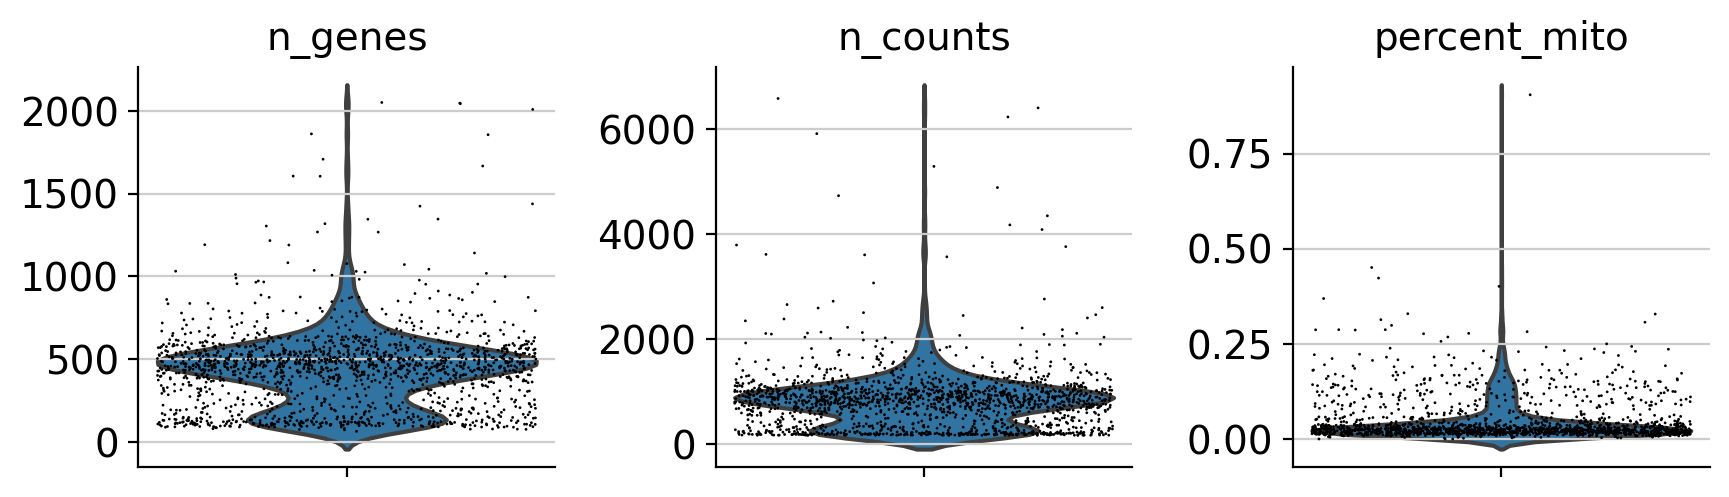

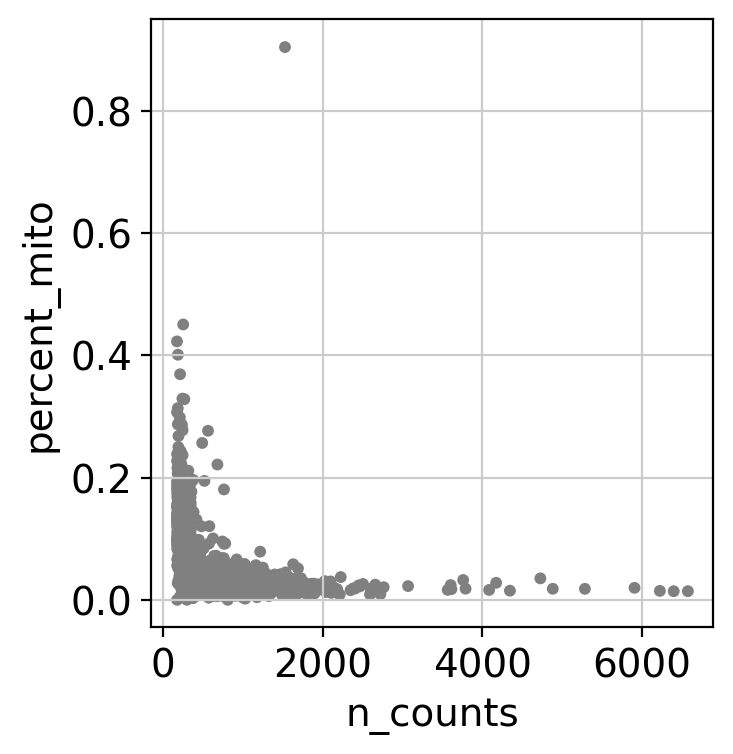

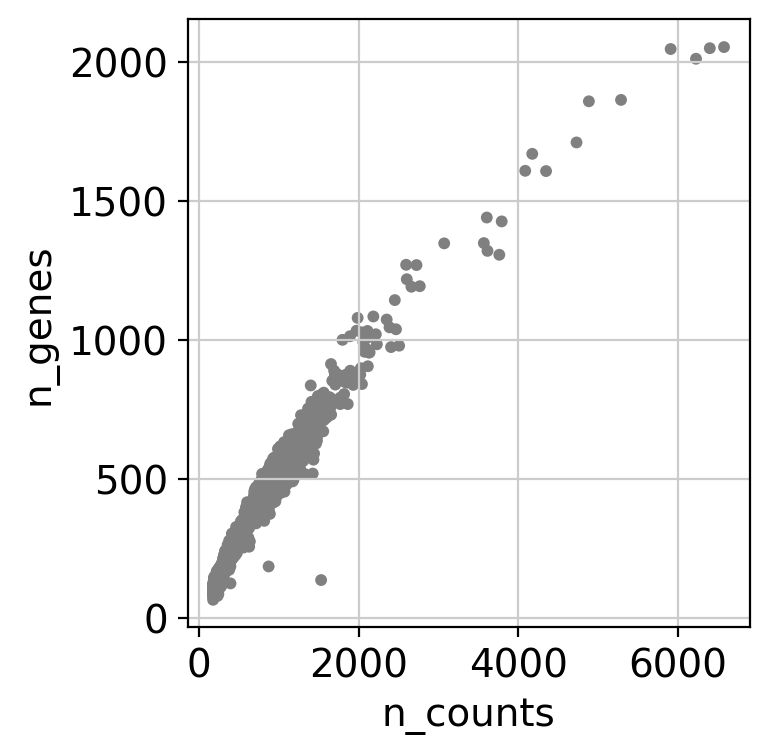

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


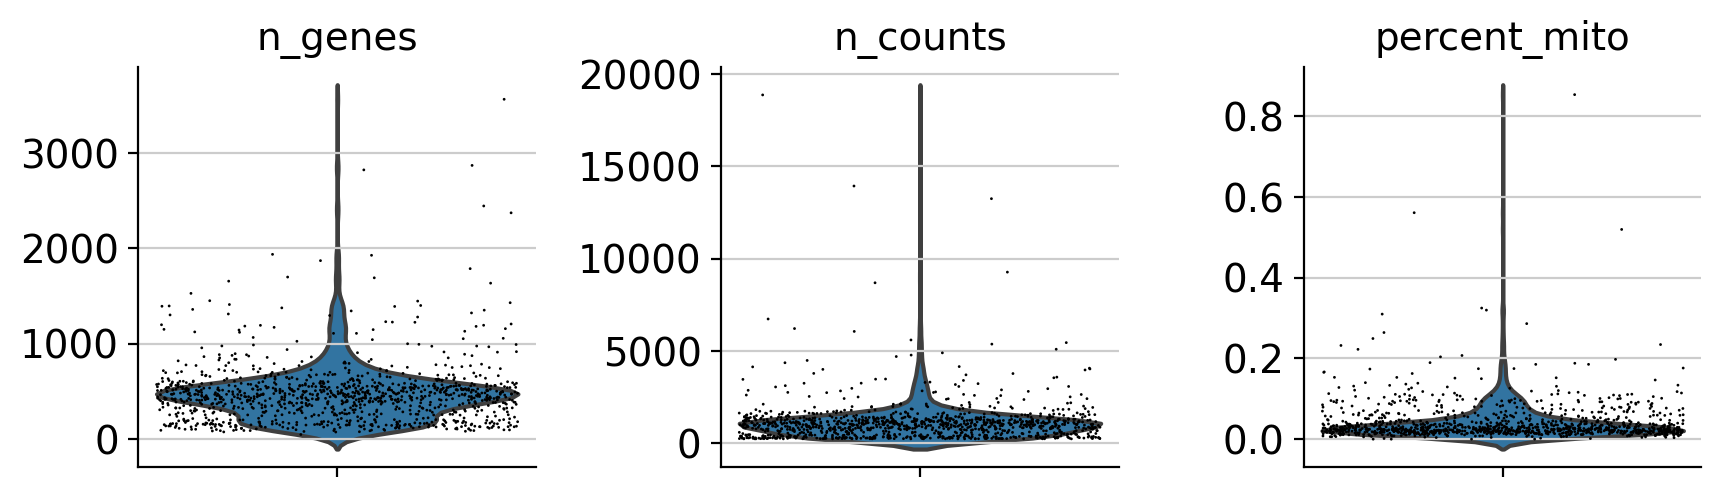

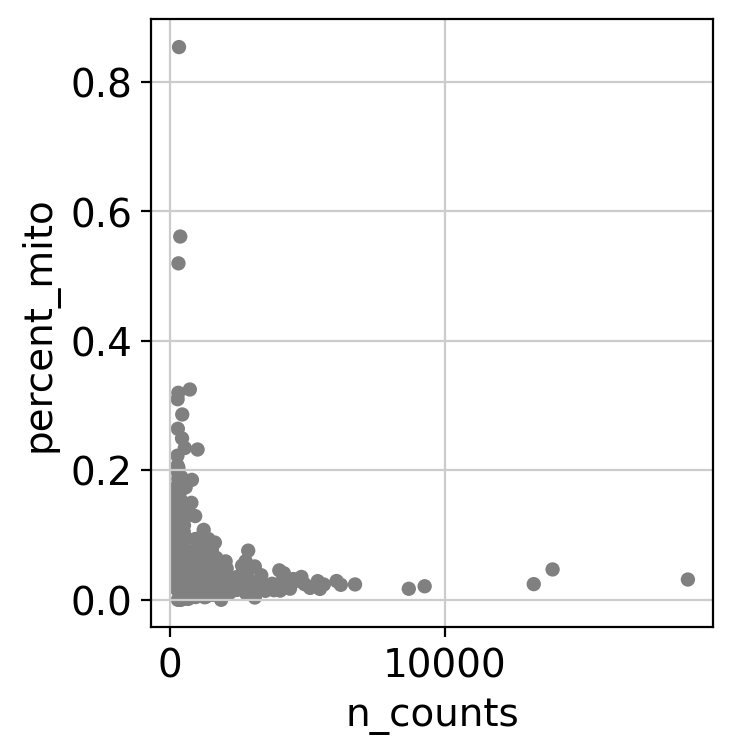

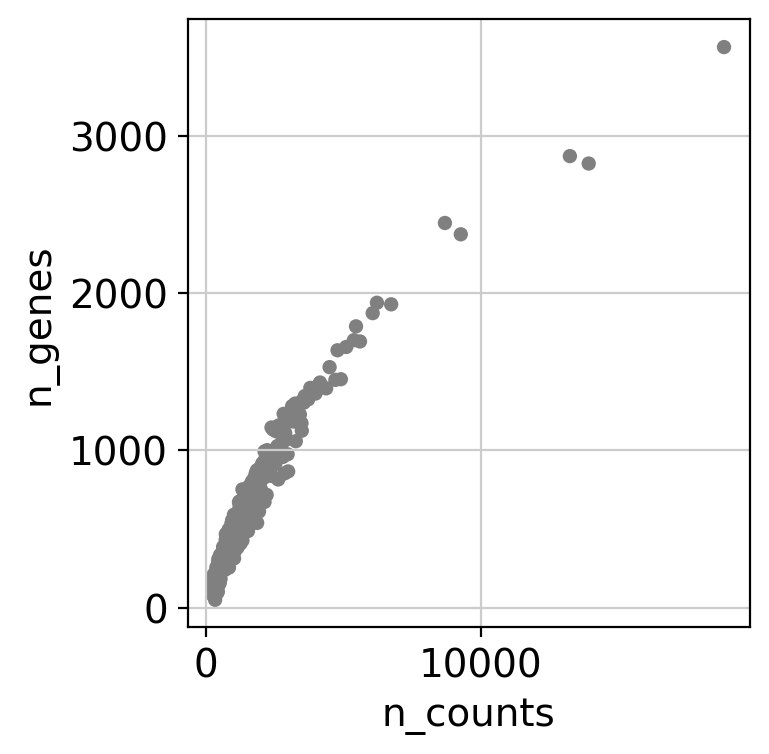

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1TCD8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


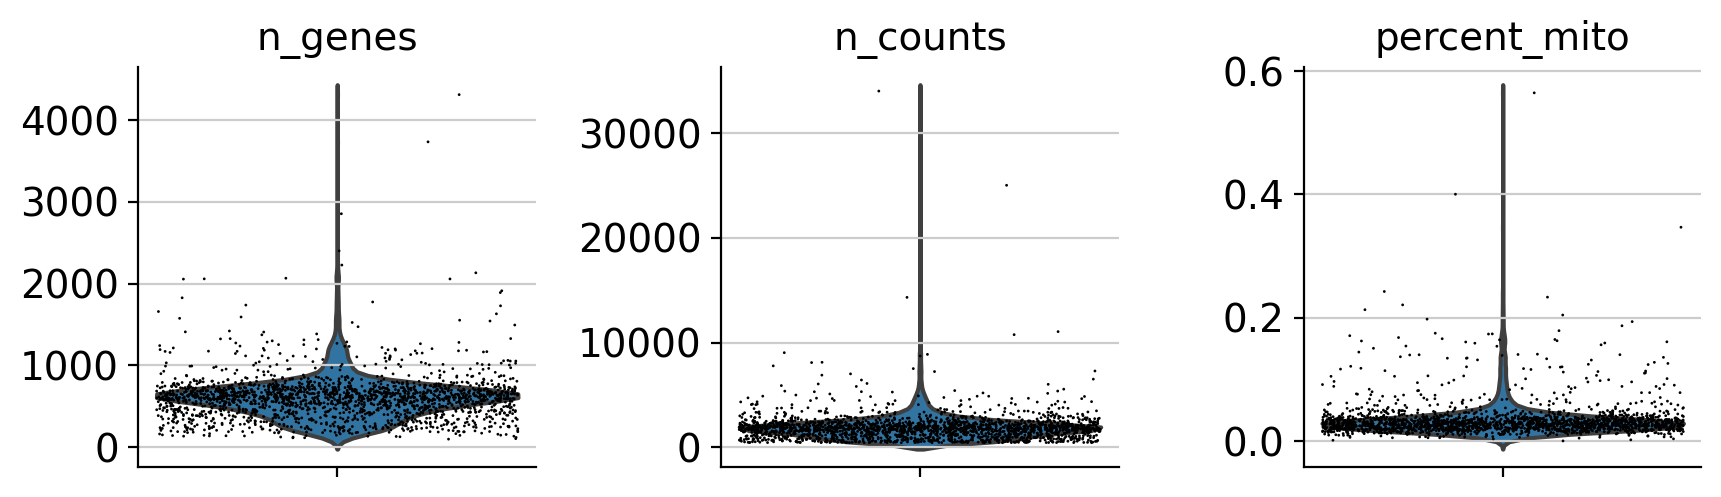

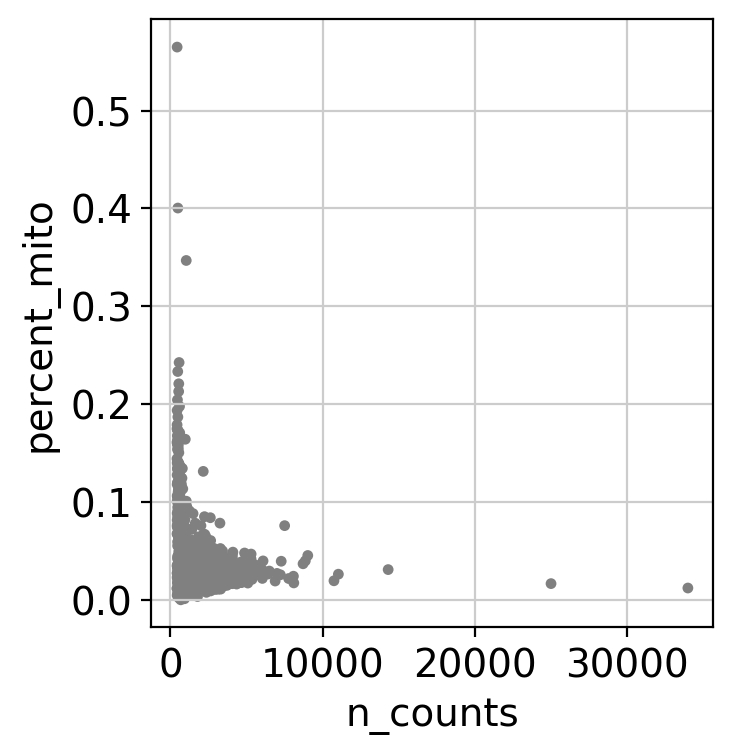

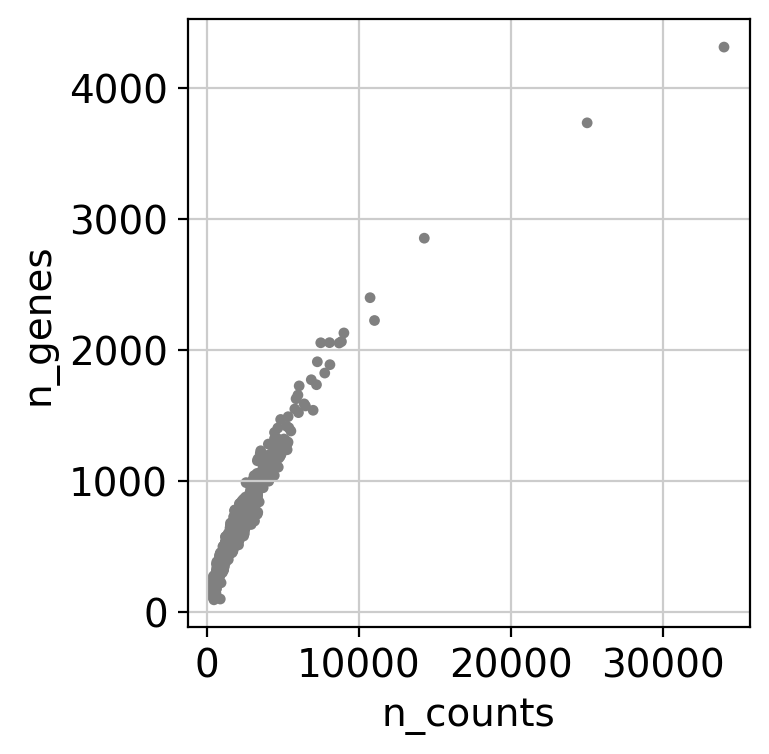

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170207_D00328_0611_AHFMGHBCXY_10x/P4/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


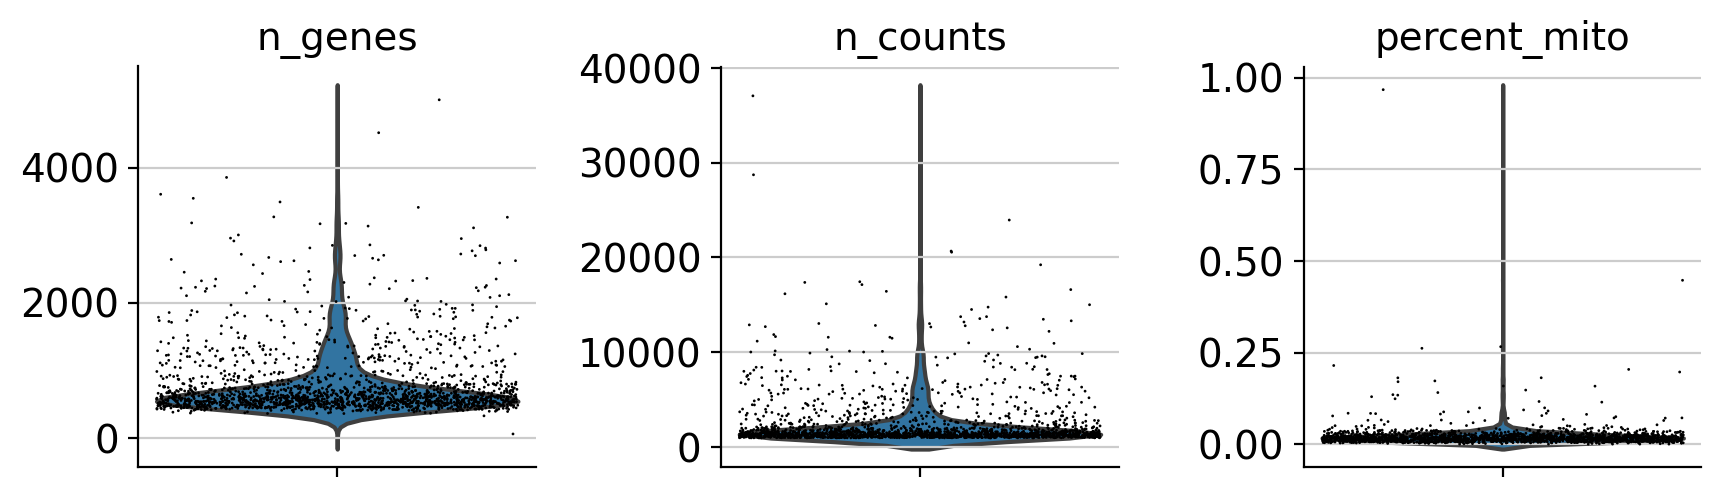

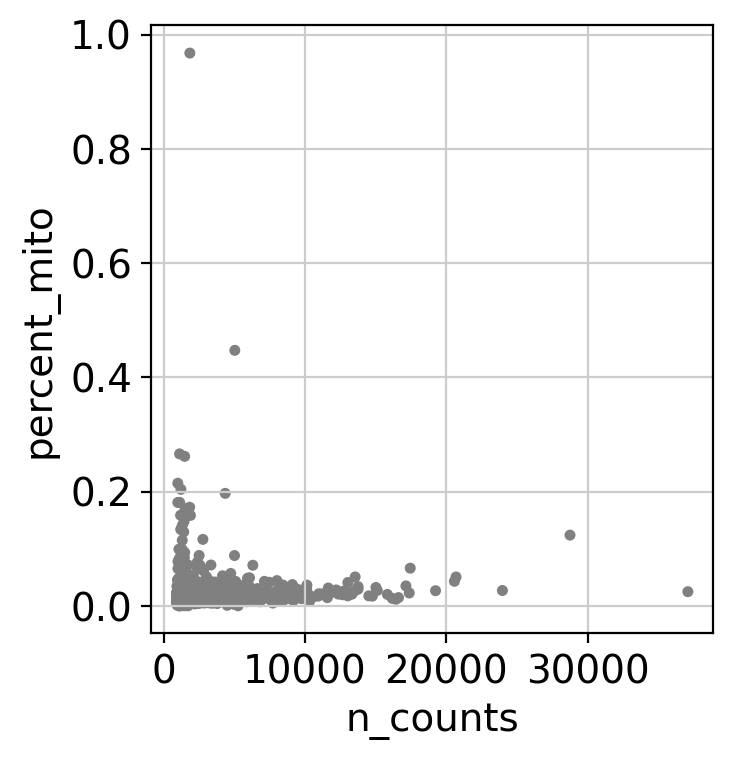

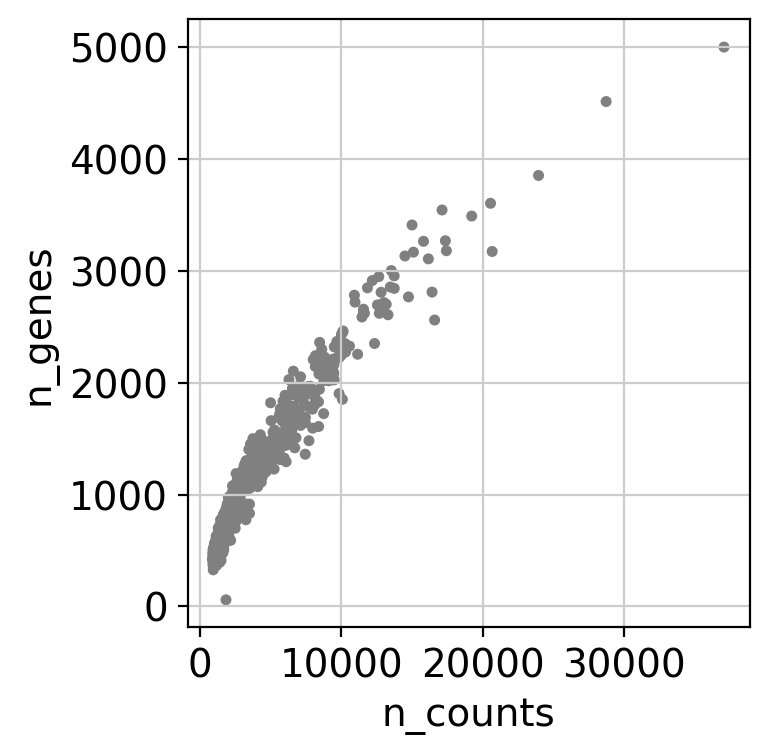

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


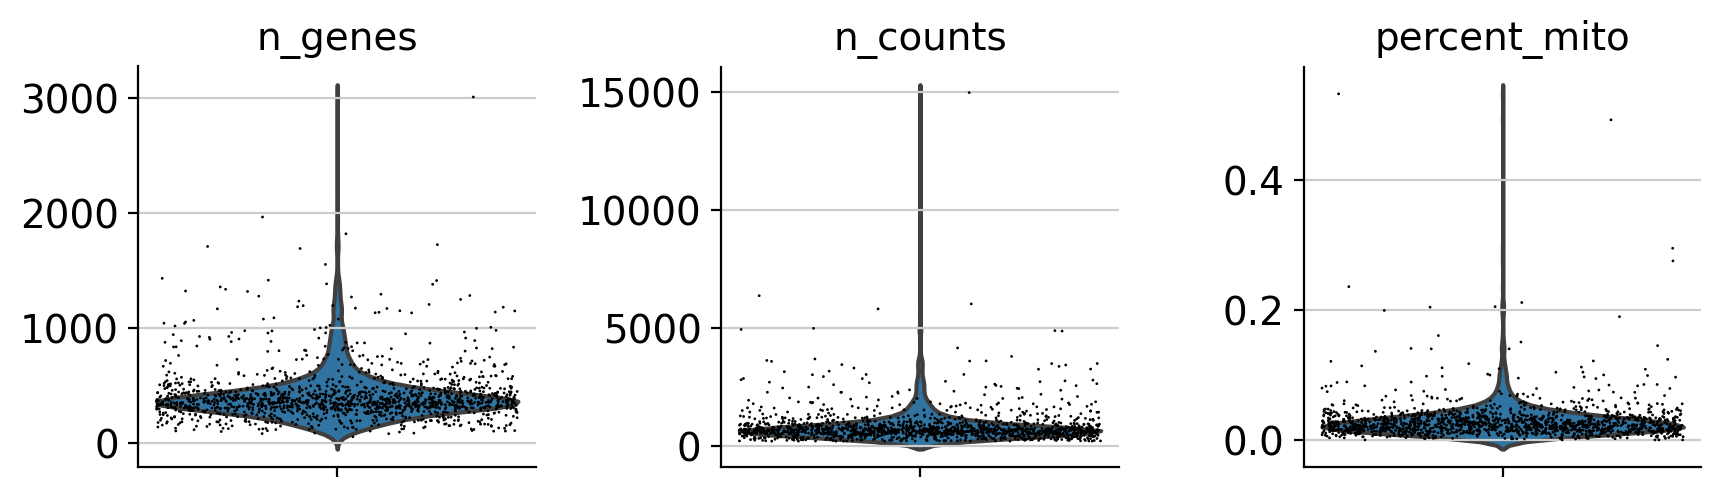

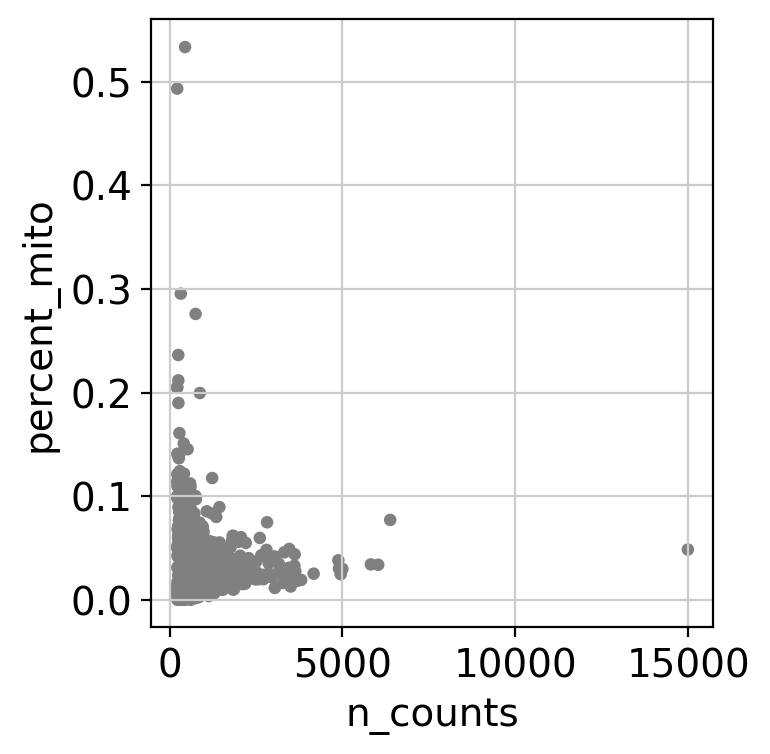

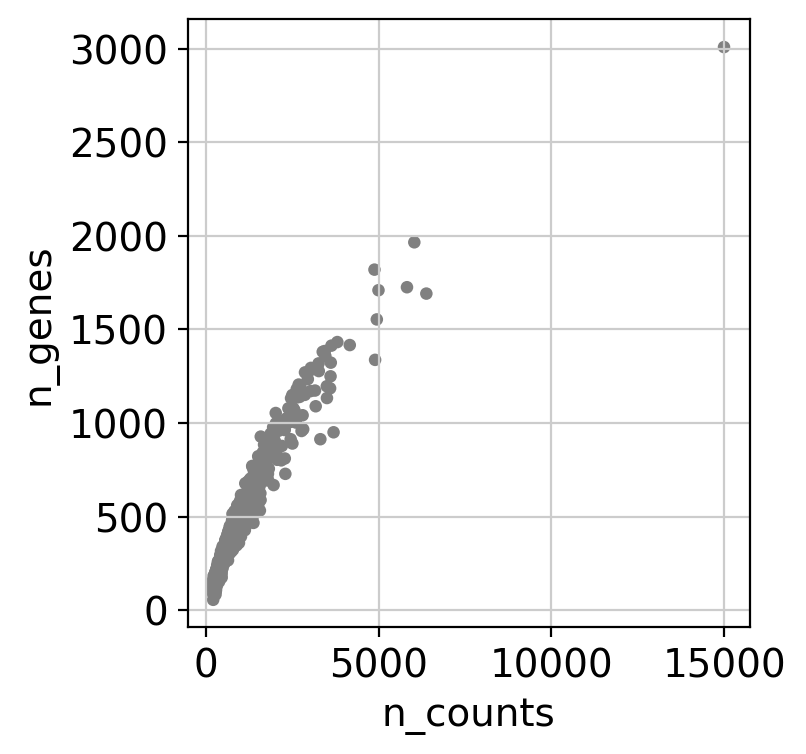

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1NCD8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


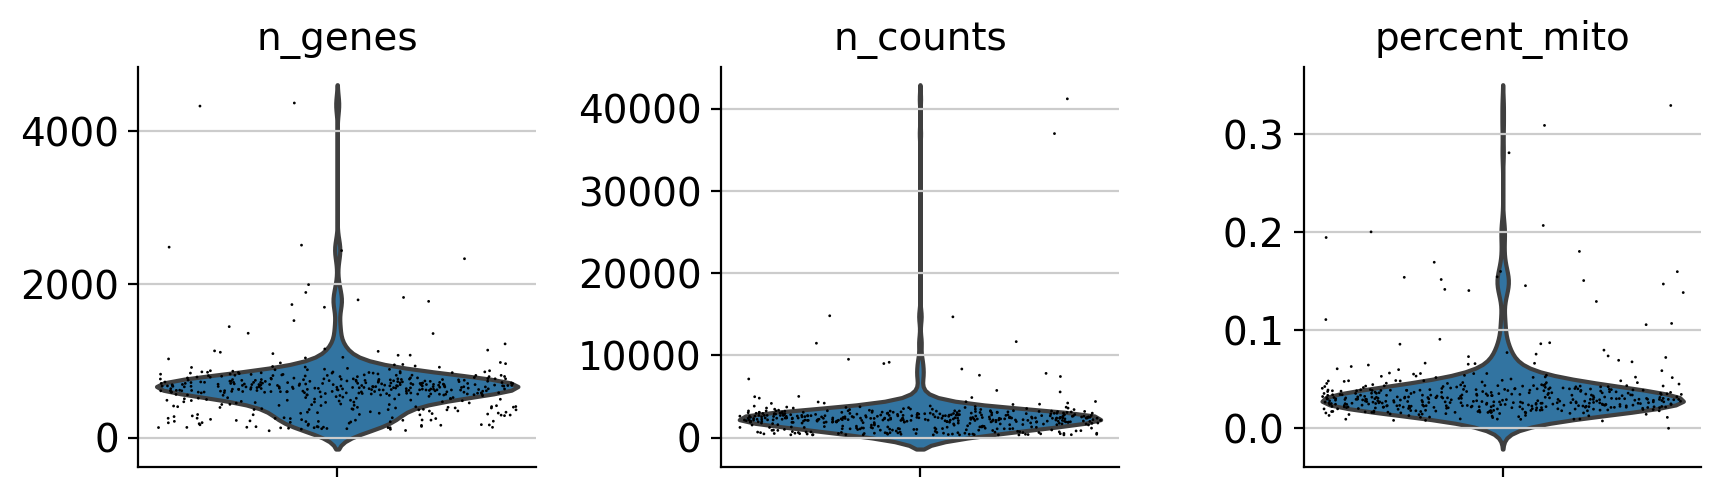

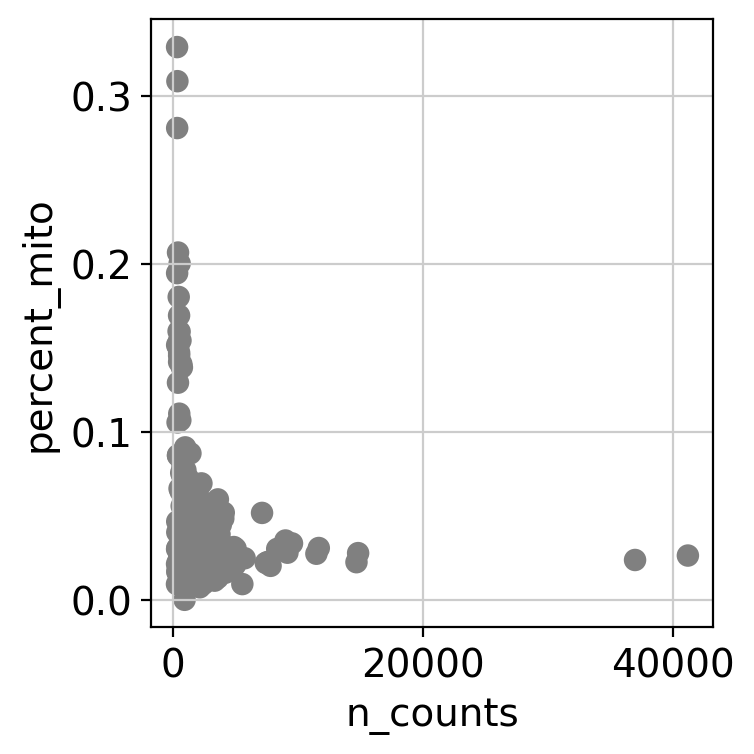

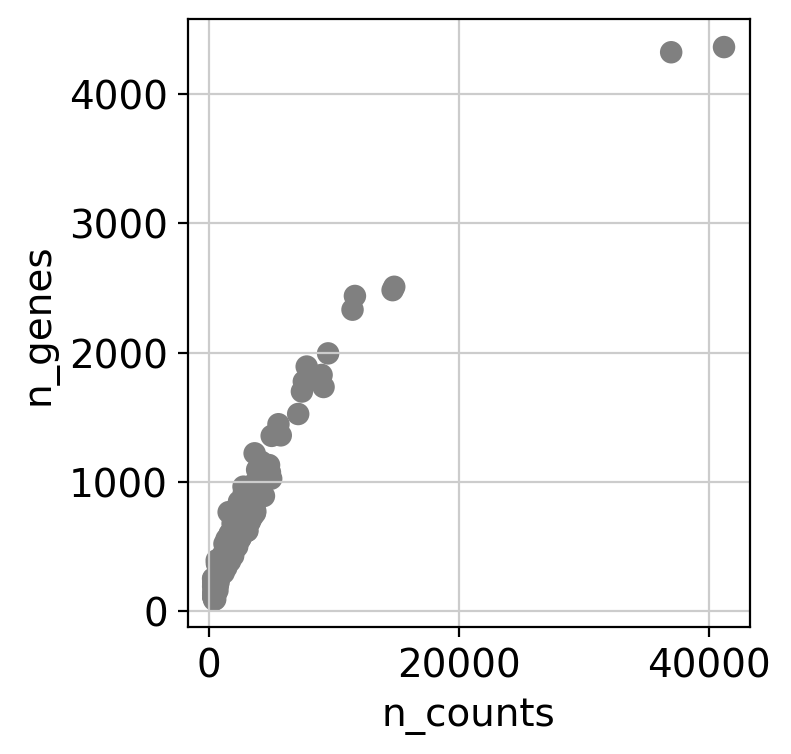

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N8/outs/filtered_gene_bc_matrices/hg19/
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


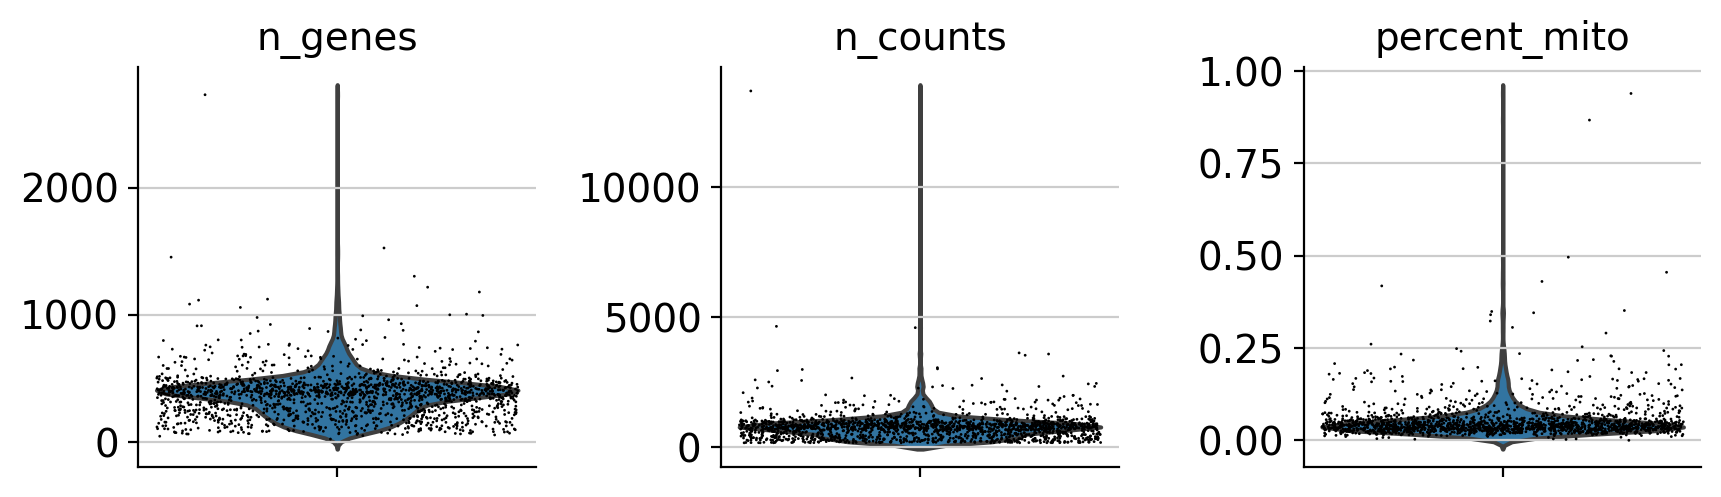

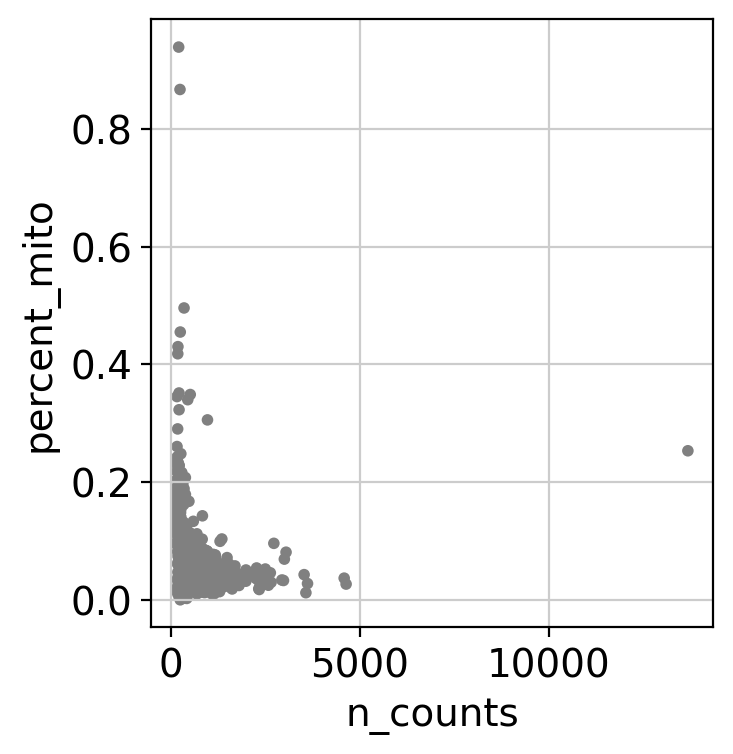

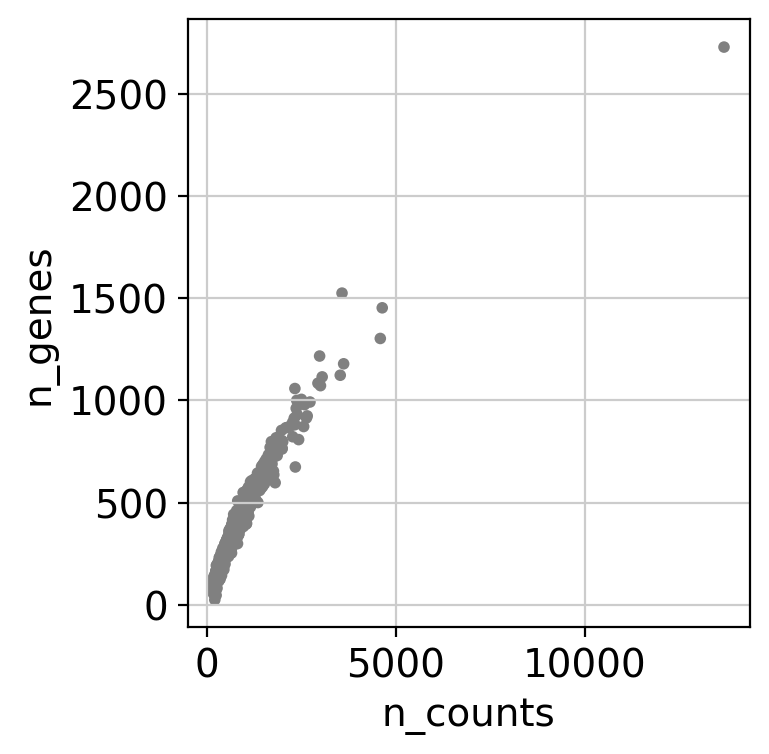

In [6]:
#Initialize dataframe to store cell counts
height = 4
width = no_wells

contamination_df = pd.DataFrame(0, index=range(height), columns=range(width))
contamination_df.rename(index={0:'Cells',1:'Platelets',2:'RBCs',3:'% cell with < 10% mito'}, inplace=True)
contamination_df.columns = RNA_files

for adata_index in range(len(RNA_adata)):
    adata = RNA_adata[adata_index]
    well = RNA_files[adata_index]
    print(well)
    #Remove platelets
    original_cell_no = adata.shape[0]
    
    print('Annotating platelet contamination and Megakaryocytes.')
    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['PF4'])].todense()

    platelets = adata[np.ravel(mat > 0)].obs.index
    no_platelets = len(platelets)
    
    platelet_info = [False] * original_cell_no
    
    index = 0
    
    for x in adata.obs.index:
        if x in platelets:
            platelet_info[index] = True
        index += 1
        
    adata.obs['platelet'] = platelet_info   
    print('Annotating RBCs')

    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['HBB'])].todense()
    
    RBCs = adata[np.ravel(mat > 1)].obs.index
    no_RBCs = len(RBCs)
    
    RBC_info = [False] * original_cell_no
    
    index = 0
    for x in adata.obs.index:
        if x in RBCs:
            RBC_info[index] = True
        index += 1

    adata.obs['RBC'] = RBC_info
    
    #Calculate quality metrics
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    #sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', percent_top=(50, 100, 200, 500), inplace=True)
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['n_genes'] = (adata.X !=0).sum(axis=1).A1
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    cells_mito_cutoff = np.sum([adata.obs['percent_mito'] < 0.1])/original_cell_no
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    contamination_df[well] = [original_cell_no, no_platelets, no_RBCs, cells_mito_cutoff]
    RNA_adata[adata_index] = adata

In [7]:
#!mkdir /ye/yelabstore3/guy_mm/exp_002/analysis/pre_processing_002
cell_count_df.loc['Platelets'] = contamination_df.loc['Platelets']
cell_count_df.loc['RBCs'] = contamination_df.loc['RBCs']
cell_count_df.loc['% cell with < 10% mito'] = contamination_df.loc['% cell with < 10% mito']

# cell_count_df.to_csv('/wynton/scratch/EM/bladder_cancer/sample_cell_counts_exp_CD8.csv')
cell_count_df.columns = sample
cell_count_df.T

,Cells,Platelets,RBCs,% cell with < 10% mito
atezo2,1302.0,0.0,0.0,0.952381
atezo3,684.0,0.0,0.0,0.961988
atezo4,1650.0,0.0,0.0,0.862424
atezo5,1128.0,0.0,0.0,0.929078
soc1,1997.0,0.0,1.0,0.963946
soc2,1912.0,1.0,0.0,0.989017
soc3,1472.0,0.0,0.0,0.978940
s1normal,458.0,0.0,0.0,0.949782
s3normal,1723.0,0.0,0.0,0.916425


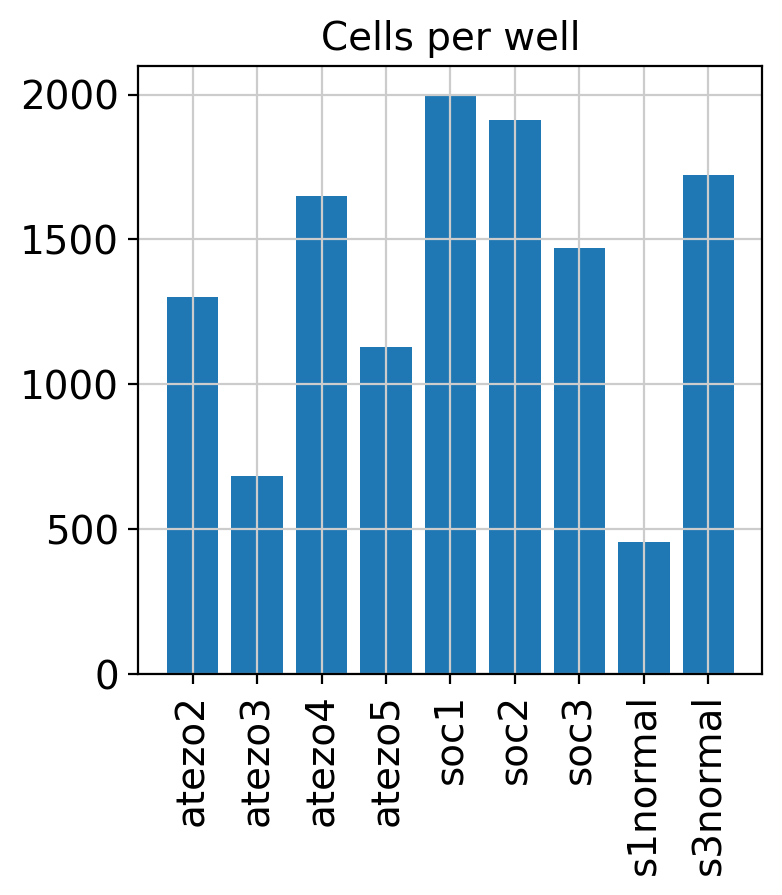

In [8]:
##Plot Cells
height = contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Cells per well")
    
# Show graphic
plt.show()

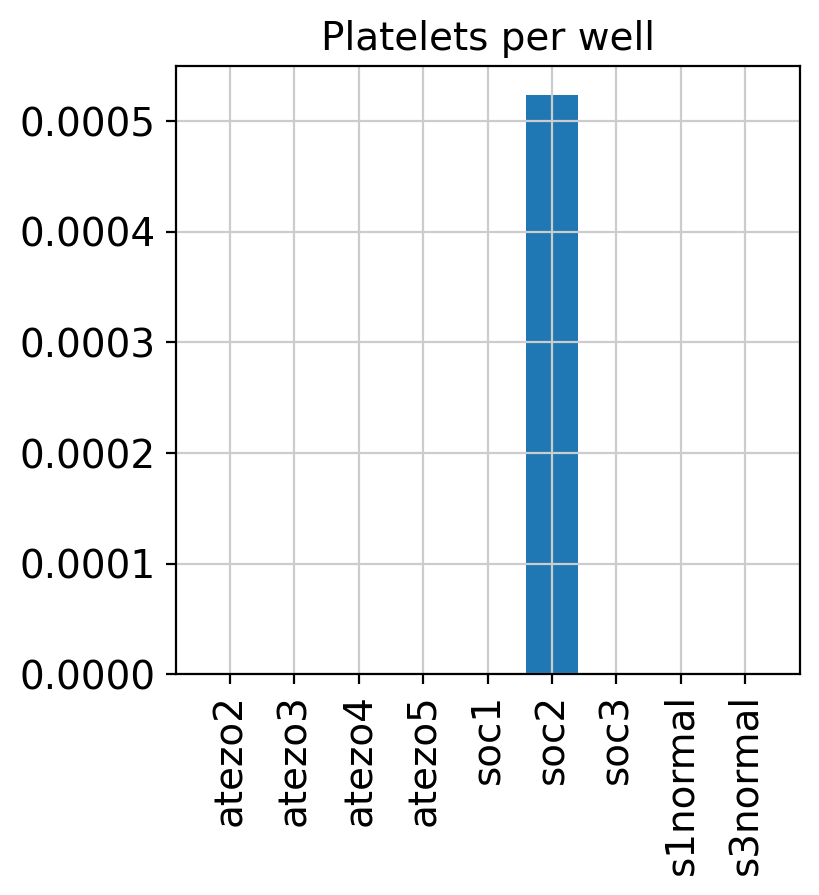

In [9]:
##Plot Platelets

height = contamination_df.iloc[1,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Platelets per well")
    
# Show graphic
plt.show()


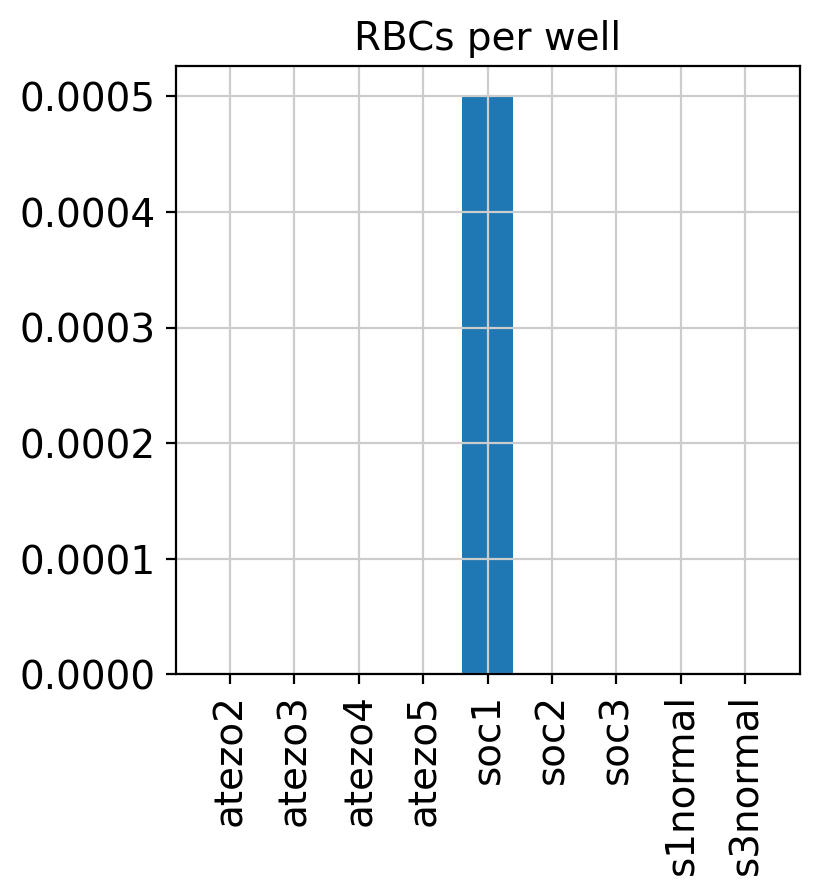

In [10]:
##Plot RBCs

height = contamination_df.iloc[2,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("RBCs per well")
    
# Show graphic
plt.show()

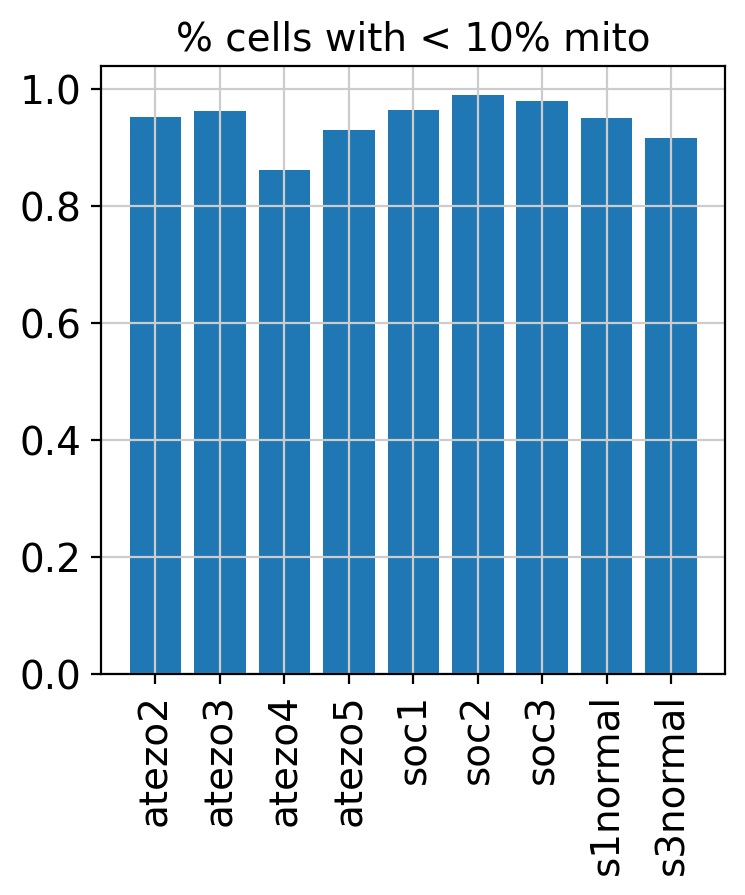

In [11]:
##Plot % mito
height = contamination_df.iloc[3,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("% cells with < 10% mito")
    
# Show graphic
plt.show()

In [12]:
path = '/wynton/group/fong/hyang7/bladder_blood_analysis/obj/preprocessing/'

adata_files = sample
adata_files = [x+"_CD8TILs" for x in adata_files]

adata_files = [path + x + '.h5ad' for x in adata_files]

for index in range(len(RNA_adata)):
    RNA_adata[index].write(adata_files[index])